In [1]:
from graph_of_words import GraphOfWords
import nltk
import numpy as np
import matplotlib.pyplot as plt
from torchtext.datasets import AG_NEWS
from torchdata.datapipes.iter import IterDataPipe
from nltk.stem import PorterStemmer
import torchtext
import torchdata
from collections import Counter
import re
import string
import networkx as nx
import copy
from collections import deque
from amplpy import AMPL
import cvxpy as cp
import cvxopt
import math
from sklearn.decomposition import PCA as sk_PCA
import gensim
from gensim.models.doc2vec import Doc2Vec
import os
import pandas as pd

In [2]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to C:\Users\Junkai
[nltk_data]     XIA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Junkai
[nltk_data]     XIA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Stemming
ps=PorterStemmer()

In [4]:
stopwords=nltk.corpus.stopwords.words('english')
stopwords[:5]

['i', 'me', 'my', 'myself', 'we']

In [5]:
# build tokens
train = AG_NEWS(split='train')
train_iter=iter(train)
def tokenize(line):
    res=[]
    raw=[ps.stem(w.lower()) for w in line.split() if (w.lower() not in stopwords and re.match(u'[a-z]', w, flags=re.I))]
    for item in raw:
        if "\\" in item:
            res+=[ps.stem(w.lower()) for w in item.split("\\")]
        else:
            res.append(item)
    return res

tokens = []
for label, line in train:
    tokens += tokenize(line)

In [6]:
cnt_tokens=Counter(tokens)
cnt_tokens.most_common()[:5]

[('new', 21118),
 ('said', 16855),
 ('us', 12148),
 ('first', 8956),
 ('two', 8882)]

In [7]:
def build_documents(size=10):
    docs=[]
    for i in range(size):
        docs.append(next(train_iter)[1])
    return docs

In [8]:
# Documents containing several sentences
docs=build_documents(size=10)
docs

["Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.",
 'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.',
 "Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums.",
 'Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\\flows from the main pipeline in southern Iraq after\\intelligence showed a rebel militia could strike\\infrastructure, an oil official said on Saturday.',
 'Oil prices soar to all-time record, posing new menace to US economy (A

In [9]:
def remove_iso(mat):
    dim=mat.shape[0]
    d=[]
    for z in range(dim):
        if mat[z,0]==np.inf:
            d.append(z)
    mat=np.delete(mat,d,axis=0)
    mat=np.delete(mat,d,axis=1)
    return mat

def dist2Gram(D):
    n = D.shape[0]
    J = np.identity(n) - (1.0/n)*np.ones((n,n))
    G = -0.5 * J@(D@(D@J))
    return G

def factor(A):
    n = A.shape[0]
    (evals,evecs) = np.linalg.eigh(A)
    evals[evals < 0] = 0 # closest SDP matrix
    X = evecs
    sqrootdiag = np.eye(n)
    for i in range(n):
        sqrootdiag[i,i] = np.sqrt(evals[i])
    X = X.dot(sqrootdiag)
    # because default eig order is small->large
    return np.fliplr(X)

def PCA(B,K):
    x = factor(B)
    # only first K columns
    x = x[:,0:K]
    return x

def Barvinok(B, K):
    n = B.shape[0]
    X = factor(B)
    y = (1/math.sqrt(K))*np.random.multivariate_normal(np.zeros(n*K), np.identity(n*K))
    y = np.reshape(y, (K, n))
    x = np.transpose(np.dot(y,X.T))
    return x

In [10]:
def writeRlz(graph, n , rlzfn):
    rlz = open(rlzfn, "w")
    print("param Kdim := 2;", file=rlz)
    print("param n := "+str(graph.number_of_nodes())+";", file=rlz)
    print("param : E : c I :=", file=rlz)
    for i in range(n):
        wi=list(graph.nodes)[i]
        for k in range(i+1,n):
            wk=list(graph.nodes)[k]
            if graph.has_edge(wi, wk):
                print(str(i+1) + " " + str(k+1) + " " + str(graph.get_edge_data(wi, wk)["weight"])+" "+str(1), file=rlz)
    print(";", file=rlz)
    rlz.close()
    return

def readDat(filename):
    edgeflag = False # true while reading edges
    Kdim = 3
    n = 0
    E = list()
    with open(filename) as f:
        for line in f:
            # look at file line by line
            line = line.strip()
            if len(line) > 0:       
                if line[0] != '#':
                    # line non-empty and non-comment
                    if edgeflag:
                        if line[0] == ';':
                            # if only a ';' then we're closing the edge section
                            edgeflag = False
                        else:
                            # reading uncommented edge data
                            cols = [c for c in line.split() if not '#' in c]
#                             print(cols)
                            if len(cols) >= 6:
                                e = (int(cols[0]), int(cols[1]), float(cols[4]), float(cols[5]))
                            elif len(cols) >= 4:
                                e = (int(cols[0]), int(cols[1]), float(cols[2]), float(cols[2]))
                                if e[2] > e[3]:
                                    print("readDat: WARNING: interval weight[", e[2], ",", e[3], "] empty, setting to", e[2])
                                    e[3] = e[2]
                            else:
                                print("readDat: ERROR: line", linecount, "has < 4 columns")
                                exit('abort')
                            E.append(e)
                    else:
                        if line.replace(" ","")[0:7] == 'param:E':
                            # we're in the edge section now
                            edgeflag = True
                        elif line.replace(" ","")[0:9] == 'paramKdim':
                            # parse line defining Kdim
                            Kdimstr = line.split()[3]
                            if Kdimstr[-1] == ';':
                                Kdimstr = Kdimstr[0:-1]
                            Kdim = int(Kdimstr)
                        elif line.replace(" ","")[0:6] == 'paramn':
                            # parse line defining n
                            nstr = line.split()[3]
                            if nstr[-1] == ';':
                                nstr = nstr[0:-1]
                            n = int(nstr)
    return (Kdim, n, E)

In [11]:
LPsolver = "cplex"
NLPsolver = "ipopt"
projmethod = "Barvinok"
# projmethod = "PCA"

In [12]:
class Graph_of_words():
    def __init__(self, documents):
        self.documents=documents     #D 【sentence1，sentence2，...】
        self.stopwords=nltk.corpus.stopwords.words('english')+[string.punctuation]
        self.tokens=[]               # token of the corresponding document
        self.dictionnary=[]          # set of all the words of the whole document
        self.n=None                  # number of words of the whole doc =len(dictionnary)
        self.m=len(self.documents)   #  num of sentences
        self.length=0                #  num of nodes of the longest sentence
        self.graphs=[]               # one graph for each sentence
        self.word_vec=[]             # set of the word vectors of each sentence
        self.coords=[]
        self.Kdim=None               # dimension needed
        
        
        
    def preprocessing(self):
        # tokenize, build dictionnary
        # it reads a text file, “cleans” it, and splits it into sentences
        for sentence in self.documents:
            t_temp=tokenize(sentence)
            self.tokens.append(t_temp)
            self.length+=len(t_temp)
            self.dictionnary+=[ps.stem(w.lower()) for w in sentence.split() if (w.lower() not in self.stopwords and re.match(u'[a-z]', w, flags=re.I))]
        
        self.dictionnary=list(set(self.dictionnary))
        self.n=len(self.dictionnary)
        self.idf=np.zeros((self.n,1))
        self.tw_idf=np.zeros((self.n,self.m))

        # distance matrix of each sentence given by the graph of word
        self.metric=[]
        
    # build graph    
    def update_graph_init(self,window, g):
        n=len(window)
        for i in range(n):
            for j in range(i+1,n):
                if not g.has_edge(window[i],window[j]):
                    g.add_edge(window[i],window[j],weight=1)
                else:
                    g[window[i]][window[j]]["weight"]+=1

    def update_graph(self,window,g):
        n=len(window)
        for i in range(n-1):
            if not g.has_edge(window[i],window[n-1]):
                g.add_edge(window[i],window[n-1],weight=1)
            else:
                # The weight of the edge is equal to the number of n-grams in which the two words appear
                g[window[i]][window[n-1]]["weight"]+=1

    def graph_construction(self, window_size=4):
        #  constructs a graph-of-words (Sect. 4.2) from each sentence
        max_length=0
        for idx, doc in enumerate(self.documents):
            t_temp=self.tokens[idx]
            g_temp=nx.Graph()
            for t in self.dictionnary:
                if t in t_temp:
                    # each unique word in s is associated to a single vertex
                    g_temp.add_node(t)
            
            if len(t_temp)<window_size:
                g_temp.add_edge(t_temp[0],t_temp[1],weight=1)                  
            
            # Two words have an edge only if they appear in the same n-gram
            windows=t_temp[0:window_size]
            self.update_graph_init(windows, g_temp)
            for i in range(len(t_temp)-window_size):
                windows.pop(0)
                windows.append(t_temp[window_size+i])
                self.update_graph(windows, g_temp)
                
            self.graphs.append(g_temp)
            max_length=max(max_length,g_temp.number_of_nodes())
            
        
        self.length=max_length
                
            
#     def degree_centrality(node,g):
#         if not node in gg.nodes:
#             return 0
#         neighbors=[i for i in nx.neighbors(g,node)]        
#         return len(neighbors)/g.number_of_nodes()
    
#     def term_weighting(self,b=0.003):
#         for i in range(self.n):
#             word=self.dictionnary[i]
#             self.idf[i,0]=np.log((self.m+1)/len([d for d in self.documents if re.search(word, d, flags=re.I)]))
            
#         for i in range(self.n):
#             word=self.dictionnary[i]
#             for j in range(self.m):
#                 token_temp=self.tokens[j]
#                 g_temp=self.graphs[j]
#                 cbt_temp=Counter(token_temp)
#                 tf=cbt_temp[word]
#                 self.tw_idf[i,j]=self.idf[i,0]*(Graph_of_words.degree_centrality(word,g_temp))/(1-b+b*len(token_temp)/(self.length/self.m))
    
    
    
    def write_dat(self):
        for i in range(self.m):
            graph=self.graphs[i]
            file_name="sentence_"+str(i)+".dat"
            writeRlz(graph, graph.number_of_nodes() , file_name)
            
    # uses DG methods to map graphs-of-words to realizations        
    def _solve_dgp(self,idx,filename):
        self.Kdim, n, E = readDat(filename)
        g_temp=self.graphs[idx]
        K=g_temp.number_of_nodes()
        G = {i:dict() for i in range(n)}

        for e in E:
            i = e[0]-1 # first vertex
            j = e[1]-1 # second vertex
            w = e[2] # edge weight
            if i > j:
                t = i
                i = j
                j = t
            G[i][j] = w 
            
            
        X = cp.Variable((n,n), PSD=True)
        S = cp.Variable((n,n))
        cobj1 = sum([X[i,i] + X[j,j] - 2*X[i,j] for i in range(n) for j in G[i] if i<j])
        cobj2 = cp.trace(X)
        
        # different criteria
#         R = 2*np.random.rand(n,n) - 1
#         cobj3 = cp.trace(R@X)
        cobj4=sum([S[i,j]**2 for i in range(n) for j in range(n)])
        cobj = cobj1 + 0.1*cobj2+cobj4 # + 0.1*cobj3
        
        objective = cp.Minimize(cobj)
        constraints = [X[i,i] + X[j,j] - 2*X[i,j] == G[i][j]**2+S[i,j] for i in range(n) for j in G[i] if i<j ]
        prob = cp.Problem(objective, constraints)    
        prob.solve(solver=cp.SCS, verbose=True)
        xbar = Barvinok(X.value, K)        
        
        nlp = AMPL()
        nlp.read("dgp.mod")
        nlp.readData(filename)
        nlp.setOption('solver', NLPsolver)
        xvar = nlp.getVariable('x')

        for i in range(n):
            for k in range(self.Kdim):
                xvar[i+1,k+1].setValue(xbar[i,k])
        nlp.solve()
        xvar = nlp.getVariable('x')
        xval = xvar.getValues()
        x = np.zeros((n,self.Kdim))
        for i in range(n):
                for k in range(self.Kdim):
                    x[i,k] = xvar[i+1,k+1].value()
        
        self.word_vec.append(x)
        
    def solve_dgp(self):
        for i in range(self.m):
            file_name="sentence_"+str(i)+".dat"
            self._solve_dgp(i, file_name)
            
    # stacks these realizations onto single vectors (i.e. it concatenates the rows of a realization) and
    # zero-pads the shorter vectors to fit all vectors to a same size, yielding sentence vectors
    def _stacks(self,list_word_vec):
        avg=np.mean(list_word_vec,axis=0)
        if len(avg)>self.length:
            return avg[:self.length]
        else:
            return np.pad(avg,(0,self.length-len(avg)))
    
    # shortens the sentence vectors using dimensional reduction
    def stack(self,k=2):
        total_vec=np.zeros((self.m,self.length))
        pca= sk_PCA(n_components=k)
    
        for i in range(self.m):
            sentence_vec=self._stacks(self.word_vec[i])
            total_vec[i]=sentence_vec
       
        
        self.coords=pca.fit_transform(total_vec)
    
    

In [13]:
G=Graph_of_words(docs)
G.preprocessing()
G.dictionnary[:5]
G.graph_construction()
G.write_dat()
G.solve_dgp()
G.stack()
# edges = [(u, v) for (u, v, d) in G.graph.edges(data=True) ]
# pos = nx.spring_layout(G.graph,seed=1) 
# for idx,(key,val) in enumerate(pos.items()):
#     pos[key]=new[idx]
# nx.draw_networkx_nodes(G.graph, pos, node_size=200)
# # nx.draw_networkx_edges(G.graphs[0], pos, edgelist=elarge, width=6)
# nx.draw_networkx_edges(
#     G.graph, pos, edgelist=edges, width=4, alpha=0.1, edge_color="b", style="dashed"
# )
# nx.draw_networkx_labels(G.graph, pos, font_size=6, font_family="sans-serif")

# ax = plt.gca()
# ax.margins(0.08)
# ax.figsize=(2,1)
# plt.axis("off")
# plt.tight_layout()
# plt.show()

# for g in G.graphs:
#     print(g.edges.data())
# G.graphs[0].edges.data()
# G.graphs[0].get_edge_data('band', 'wall')["weight"]
# list(G.graphs[0].nodes)

# G.word_vec[0]
# np.mean(G.word_vec[0],axis=0)

                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Feb 14 04:31:23 PM: Your problem has 450 variables, 42 constraints, and 0 parameters.
(CVXPY) Feb 14 04:31:23 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 14 04:31:23 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 14 04:31:23 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 14 04:31:23 PM: Compiling problem (target solver=SCS).
(CVXPY) Feb 14 04:31:23 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -

-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 14 04:31:24 PM: Compiling problem (target solver=SCS).
(CVXPY) Feb 14 04:31:24 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Feb 14 04:31:24 PM: Applying reduction Dcp2Cone
(CVXPY) Feb 14 04:31:24 PM: Applying reduction CvxAttr2Constr
(CVXPY) Feb 14 04:31:24 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Feb 14 04:31:25 PM: Applying reduction SCS
(CVXPY) Feb 14 04:31:25 PM: Finished problem compilation (took 9.846e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Feb 14 04:31:25 PM: Invoki

(CVXPY) Feb 14 04:31:26 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Feb 14 04:31:26 PM: Applying reduction Dcp2Cone
(CVXPY) Feb 14 04:31:26 PM: Applying reduction CvxAttr2Constr
(CVXPY) Feb 14 04:31:26 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Feb 14 04:31:26 PM: Applying reduction SCS
(CVXPY) Feb 14 04:31:26 PM: Finished problem compilation (took 8.181e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Feb 14 04:31:26 PM: Invoking solver SCS  to obtain a solution.
------------------------------------------------------------------
	       SCS v3.2.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 1452, constraints 

(CVXPY) Feb 14 04:31:27 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Feb 14 04:31:27 PM: Applying reduction Dcp2Cone
(CVXPY) Feb 14 04:31:27 PM: Applying reduction CvxAttr2Constr
(CVXPY) Feb 14 04:31:27 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Feb 14 04:31:27 PM: Applying reduction SCS
(CVXPY) Feb 14 04:31:27 PM: Finished problem compilation (took 5.438e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Feb 14 04:31:27 PM: Invoking solver SCS  to obtain a solution.
------------------------------------------------------------------
	       SCS v3.2.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 1113, constraints 

-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 14 04:31:28 PM: Compiling problem (target solver=SCS).
(CVXPY) Feb 14 04:31:28 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Feb 14 04:31:28 PM: Applying reduction Dcp2Cone
(CVXPY) Feb 14 04:31:28 PM: Applying reduction CvxAttr2Constr
(CVXPY) Feb 14 04:31:28 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Feb 14 04:31:29 PM: Applying reduction SCS
(CVXPY) Feb 14 04:31:29 PM: Finished problem compilation (took 8.450e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Feb 14 04:31:29 PM: Invoki

(CVXPY) Feb 14 04:31:29 PM: Applying reduction Dcp2Cone
(CVXPY) Feb 14 04:31:30 PM: Applying reduction CvxAttr2Constr
(CVXPY) Feb 14 04:31:30 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Feb 14 04:31:30 PM: Applying reduction SCS
(CVXPY) Feb 14 04:31:30 PM: Finished problem compilation (took 8.020e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Feb 14 04:31:30 PM: Invoking solver SCS  to obtain a solution.
------------------------------------------------------------------
	       SCS v3.2.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 1452, constraints m: 953
cones: 	  z: primal zero / dual free vars: 653
	  s: psd vars: 300, ssize: 1
settings: eps_abs

------------------------------------------------------------------
	       SCS v3.2.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 819, constraints m: 552
cones: 	  z: primal zero / dual free vars: 381
	  s: psd vars: 171, ssize: 1
settings: eps_abs: 1.0e-05, eps_rel: 1.0e-05, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 1047, nnz(P): 324
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 3.93e+00  1.02e+01  5.04e+01  1.21e+02  1.00e-01  3.05e-03 
   175| 1.94e-05  9.72e-05  1.01e-04  6.64e+01  1.41e+00  4.86e-02 
----------------------

   375| 7.87e-06  5.36e-07  1.68e-06  5.68e+01  3.52e-01  2.18e-01 
------------------------------------------------------------------
status:  solved
timings: total: 2.18e-01s = setup: 2.20e-03s + solve: 2.16e-01s
	 lin-sys: 1.14e-02s, cones: 1.99e-01s, accel: 1.09e-03s
------------------------------------------------------------------
objective = 56.750716
------------------------------------------------------------------
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Feb 14 04:31:33 PM: Problem status: optimal
(CVXPY) Feb 14 04:31:33 PM: Optimal value: 5.675e+01
(CVXPY) Feb 14 04:31:33 PM: Compilation took 1.057e+00 seconds
(CVXPY) Feb 14 04:31:33 PM: Solver (including time spent in interface) took 2.194e-01 seconds
Ipopt 3.9.1: 

*******************************************************

   250| 3.47e-05  1.44e-04  4.93e-04  9.02e+01  4.20e-01  2.98e-01 
   300| 2.44e-05  1.07e-04  4.86e-04  9.02e+01  4.20e-01  3.56e-01 
------------------------------------------------------------------
status:  solved
timings: total: 3.56e-01s = setup: 5.07e-03s + solve: 3.51e-01s
	 lin-sys: 1.80e-02s, cones: 3.24e-01s, accel: 1.11e-03s
------------------------------------------------------------------
objective = 90.229666
------------------------------------------------------------------
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Feb 14 04:31:36 PM: Problem status: optimal
(CVXPY) Feb 14 04:31:36 PM: Optimal value: 9.023e+01
(CVXPY) Feb 14 04:31:36 PM: Compilation took 1.935e+00 seconds
(CVXPY) Feb 14 04:31:36 PM: Solver (including time spent in interface) took 3.570e-01 seconds
Ip

------------------------------------------------------------------
	       SCS v3.2.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 648, constraints m: 437
cones: 	  z: primal zero / dual free vars: 301
	  s: psd vars: 136, ssize: 1
settings: eps_abs: 1.0e-05, eps_rel: 1.0e-05, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 828, nnz(P): 256
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 9.31e-01  9.14e+00  4.15e+01  6.57e+01  1.00e-01  2.38e-03 
   125| 6.13e-06  4.88e-05  3.45e-05  3.40e+01  3.21e-01  2.68e-02 
-----------------------

In [14]:
G.coords

array([[ 0.14079495, -0.00910394],
       [-0.07077429, -0.02785488],
       [-0.04741787, -0.00321093],
       [ 0.00946465, -0.04173909],
       [-0.04741807, -0.00321186],
       [-0.04741787, -0.00321096],
       [-0.03338841,  0.08876631],
       [-0.04308459, -0.01476993],
       [ 0.21118214,  0.00920912],
       [-0.07194063,  0.00512616]])

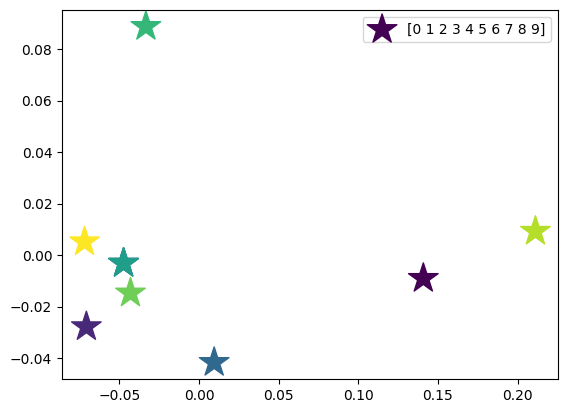

In [15]:
plt.figure()
plt.scatter(G.coords[:,0],G.coords[:,1],s=500,c=np.arange(len(G.coords)),marker="*",label=np.arange(len(G.coords)))
plt.legend()
plt.show()

In [16]:
def get_text(file):
    data_text=pd.read_table(file)
    return data_text

In [17]:
path_text_dataset='reviews_data.txt'
text_dataset=get_text(path_text_dataset).values

text_dataset=[item[-2] for item in text_dataset]
text_dataset[:5]

['Stayed two nights at Aloft on the most recent trip to China. The hotel was very modern and clean. The room was spotless and a comfortable king sized bed (as far as soft beds go in China). The staff was very punctual and went out of the way to help my every need, including going to a store across the street to purchase a China Mobile SIM card for me. The buffet breakfast was okay, nothing to write home about. The 42” LCD screen had movies on demand for 20RMB and had a good selection of western channels including HBO, CNN, BBC, Star World etc… The gym was small, had a selection of basic weights and one cable machine, there was however 6 new TechnoGym cardio machines with built in LCD TVs which were very good. The location is a bit out of the way to the central areas of Beijing, but it is better suited for my needs as I need to be in the Haidian district. Being SPG Platinum there were no upgrades to a better room, because Aloft has a policy of not doing any upgrades. The Sheraton next d

In [18]:
TaggedDocument=gensim.models.doc2vec.TaggedDocument

In [19]:
def X_text(sentences):
    X=[]
    for i,text in enumerate(sentences):
        if not isinstance(text,str):
            continue
        words=text.split(" ") 
        l=len(words)
        words=words[:-2]
        document=TaggedDocument(words,tags=[i])
        X.append(document)
    return X

In [20]:
X_documents=X_text(text_dataset)
X_documents

[TaggedDocument(words=['Stayed', 'two', 'nights', 'at', 'Aloft', 'on', 'the', 'most', 'recent', 'trip', 'to', 'China.', 'The', 'hotel', 'was', 'very', 'modern', 'and', 'clean.', 'The', 'room', 'was', 'spotless', 'and', 'a', 'comfortable', 'king', 'sized', 'bed', '(as', 'far', 'as', 'soft', 'beds', 'go', 'in', 'China).', 'The', 'staff', 'was', 'very', 'punctual', 'and', 'went', 'out', 'of', 'the', 'way', 'to', 'help', 'my', 'every', 'need,', 'including', 'going', 'to', 'a', 'store', 'across', 'the', 'street', 'to', 'purchase', 'a', 'China', 'Mobile', 'SIM', 'card', 'for', 'me.', 'The', 'buffet', 'breakfast', 'was', 'okay,', 'nothing', 'to', 'write', 'home', 'about.', 'The', '42”', 'LCD', 'screen', 'had', 'movies', 'on', 'demand', 'for', '20RMB', 'and', 'had', 'a', 'good', 'selection', 'of', 'western', 'channels', 'including', 'HBO,', 'CNN,', 'BBC,', 'Star', 'World', 'etc…', 'The', 'gym', 'was', 'small,', 'had', 'a', 'selection', 'of', 'basic', 'weights', 'and', 'one', 'cable', 'machine,

In [21]:
def train_text(text_train,size=100,epochs=10):
    model=Doc2Vec(text_train,min_count=1,window=3,vector_size=size,sample=1e-3,negative=5,epochs=epochs)
    model.train(text_train,total_examples=model.corpus_count,epochs=model.epochs)
    return model

In [22]:
model_text=train_text(X_documents)
if not os.path.exists('./WE_models'):
    os.mkdir('./WE_models')
model_text.save('WE_models/d2v_100D')

In [23]:
model_text=Doc2Vec.load('WE_models/d2v_100D')

In [24]:
def text2vec(text_train,alpha=0.05, min_alpha=0.025, epochs=10):
    list_text=[]
    for sentence in text_train:
        words=sentence.split(" ")
        vec=model_text.infer_vector(doc_words=words, alpha=alpha, min_alpha=min_alpha, epochs=epochs).tolist()
        list_text.append(vec)
    return np.array(list_text)

In [25]:
X_train_text_vec=text2vec(docs,alpha=0.05, min_alpha=0.025, epochs=10)
X_train_text_vec.shape

(10, 100)

In [26]:
pca= sk_PCA(n_components=2)
        
gensim_coords=pca.fit_transform(X_train_text_vec)
gensim_coords

array([[-1.03432599,  2.23517203],
       [-0.83317424, -0.04807649],
       [-1.47706597, -0.46211342],
       [-1.24067622, -0.6166205 ],
       [-0.75902788, -1.82986087],
       [-0.69189588, -2.01030035],
       [ 1.42696901,  2.24225468],
       [-0.45159559, -1.02722313],
       [ 5.13281378, -1.05860615],
       [-0.07202101,  2.57537421]])

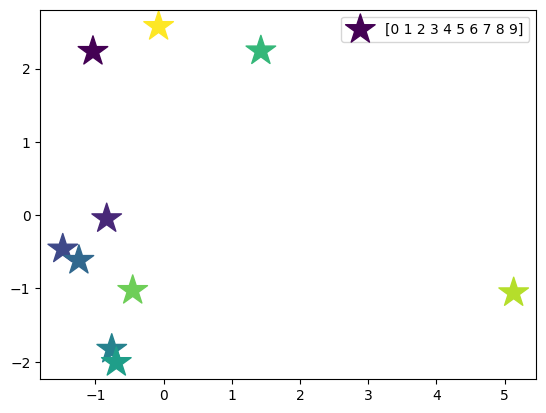

In [27]:
plt.figure()
plt.scatter(gensim_coords[:,0],gensim_coords[:,1],s=500,c=np.arange(len(gensim_coords)),marker="*",label=np.arange(len(gensim_coords)))
plt.legend()
plt.show()